# Muscle simulation

Marcos Duarte

Let's implement a program to simulate the 3-component Hill-type muscle model we described in [Muscle modeling](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleModeling.ipynb) and illustrated below:

<div class='center-align'><figure><img src="./../images/muscle_hill.png" width=400 alt="Hill-type muscle model."/><figcaption><i>Figure 1. A Hill-type muscle model with three components: two for the muscle, an active contractile element, $\mathsf{CE}$, and a passive elastic element in parallel, $\mathsf{PE}$, with the $\mathsf{CE}$, and one component for the tendon, an elastic element in series, $\mathsf{SE}$, with the muscle. $\mathsf{L_{MT}}$: muscle–tendon length, $\mathsf{L_T}$: tendon length, $\mathsf{L_M}$: muscle fiber length, $\mathsf{F_T}$: tendon force, $\mathsf{F_M}$: muscle force, and $α$: pennation angle.</i></figcaption></div>

The following relationships are true for the model:

$$ \begin{array}{l}
L_{MT} = L_{T} + L_M\cos\alpha  \\
\\
L_M = L_{CE} = L_{PE} \\
\\
\dot{L}_M = \dot{L}_{CE} = \dot{L}_{PE} \\
\\
F_{M} = F_{CE} + F_{PE} 
\end{array} $$

If we assume that the muscle–tendon system is at equilibrium, that is, muscle, $F_{M}$, and tendon, $F_{T}$, forces are in equlibrium at all times, the following equation holds (and that a muscle can only pull):

$$ F_{T} = F_{SE} = F_{M}\cos\alpha $$

## Pennation angle

The pennation angle will vary during muscle activation; for instance, Kawakami et al. (1998) showed that the pennation angle of the medial gastrocnemius muscle can vary from 22$^o$ to 67$^o$ during activation. The most used approach is to assume that the muscle width (defined as the length of the perpendicular line between the lines of the muscle origin and insertion) remains constant (Scott & Winter, 1991):

$$ w = L_{M,0} \sin\alpha_0 $$

The pennation angle as a function of time will be given by:

$$ \alpha = \sin^{-1} \left(\frac{w}{L_M}\right) $$

The cosine of the pennation angle can be given by (if $L_M$ is known):

$$ \cos \alpha = \frac{\sqrt{L_M^2-w^2}}{L_M} = \sqrt{1-\left(\frac{w}{L_M}\right)^2} $$

or (if $L_M$ is not known):

$$ \cos \alpha = \frac{L_{MT}-L_T}{L_M} = \frac{1}{\sqrt{1 + \left(\frac{w}{L_{MT}-L_T}\right)^2}} $$

## Muscle force

In general, the dependence of the force of the contractile element with its length and velocity and with the activation level are assumed independent of each other:

$$ F_{CE}(a, L_{CE}, \dot{L}_{CE}) = a \: f_l(L_{CE}) \: f_v(\dot{L}_{CE}) \: F_{M0} $$

where $f_l(L_M)$ and $f_v(\dot{L}_M)$ are mathematical functions describing the force-length and force-velocity relationships of the contractile element (typically these functions are normalized by $F_{M0}$, the maximum isometric (at zero velocity) muscle force, so we have to multiply the right side of the equation by $F_{M0}$).  

And for the muscle force:

$$ F_{M}(a, L_M, \dot{L}_M) = \left[a \: f_l(L_M)f_v(\dot{L}_M) + F_{PE}(L_M)\right]F_{M0} $$

This equation for the muscle force, with $a$, $L_{M}$, and $\dot{L}_{M}$ as state variables, can be used to simulate the dynamics of a muscle given an excitation and determine the muscle force and length. One approach is to rearrange the equation, invert the expression for $f_v$, and integrate the resulting first-order ordinary differential equation (ODE):

$$ \dot{L}_M = f_v^{-1}\left(\frac{F_{SE}(L_{MT}-L_M\cos\alpha)/\cos\alpha - F_{PE}(L_M)}{a f_l(L_M)}\right) $$

Although the equation for the muscle force doesn't have numerical singularities, the differential equation for muscle velocity has four ([OpenSim Millard 2012 Muscle Models](http://simtk-confluence.stanford.edu:8080/display/OpenSim/Millard+2012+Muscle+Models)):

When $a \rightarrow 0$; when $f_l(L_M) \rightarrow 0$; when $\alpha \rightarrow \pi/2$; and when $\partial f_v/\partial v \rightarrow 0 $.

The following solutions can be employed to avoid the numerical singularities ([OpenSim Millard 2012 Muscle Models](http://simtk-confluence.stanford.edu:8080/display/OpenSim/Millard+2012+Muscle+Models)):   

Adopt a minimum value for $a$; e.g., $a_{min}=0.01$; adopt a minimum value for $f_l(L_M)$; e.g., $f_l(0.1)$; adopt a maximum value for pennation angle; e.g., constrain $\alpha$ to $\cos\alpha > 0.1 \; (\alpha < 84.26^o)$; and make the slope of $f_V$ at and beyond maximum velocity different than zero (for both concentric and excentric activations). We will adopt these solutions to avoid singularities in the simulation of muscle mechanics. A probem of imposing values to variables as described above is that we can make the ordinary differential equation numerically stiff, which will increase the computational cost of the numerical integration. A better solution would be to modify the model to not have these singularities (see [OpenSim Millard 2012 Muscle Models](http://simtk-confluence.stanford.edu:8080/display/OpenSim/Millard+2012+Muscle+Models)).  

## Simulation

Let's simulate muscle dynamics using the Thelen2003Muscle model we defined in [Muscle modeling](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleModeling.ipynb). For the simulation of the Thelen2003Muscle, we simply have to integrate the equation (this equation already contains the terms for actvation and force-length dependence):

$$ V_M = (0.25+0.75a)\,V_{Mmax}\frac{\bar{F}_M-a\bar{f}_{l,CE}}{b}  $$ 

where

$$ 
b = \left\{ 
  \begin{array}{l l l}
    a\bar{f}_{l,CE} + \bar{F}_M/A_f \quad & \text{if} \quad \bar{F}_M \leq a\bar{f}_{l,CE} & \text{(shortening)} \\
    \\
    \frac{(2+2/A_f)(a\bar{f}_{l,CE}\bar{f}_{CEmax} - \bar{F}_M)}{\bar{f}_{CEmax}-1} \quad & \text{if} \quad \bar{F}_M > a\bar{f}_{l,CE} & \text{(lengthening)} 
\end{array} \right.
$$ 

We could run the simulation using [OpenSim](https://simtk.org/home/opensim); it would be more accurate and faster. But for fun, let's program in Python.

All the necessary functions for the Thelen2003Muscle model described in [Muscle modeling](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleModeling.ipynb) were grouped in one file (module), `muscles.py`. Let's import the necessary Python libraries and customize the environment in order to run some simulations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib nbagg 
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.size'] = 13
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rc('axes', grid=False, labelsize=14, titlesize=16, ymargin=0.05)
matplotlib.rc('legend', numpoints=1, fontsize=11)
# import the muscles.py module
import sys
sys.path.insert(1, r'./../functions')
import muscles

The `muscles.py` module contains the class `Thelen2003()` which has the functions we want to use. For such, we need to create an instance of this class:

In [2]:
ms = muscles.Thelen2003()

Now, we need to enter the parameters and states for the simulation: we can load files with these values or enter as input parameters when calling the function (method) '`set_parameters()`' and '`set_states()`'. If nothing if inputed, these methods assume that the parameters and states are stored in the files '`muscle_parameter.txt`' and '`muscle_state.txt`' inside the directory '`./../data/`'. Let's use some of the parameters and states from an exercise of the chapter 4 of Nigg and Herzog (2006).

In [3]:
ms.set_parameters()
ms.set_states()

The parameters were successfully loaded and are stored in the variable P.
"lt0" value "" was replaced by NaN.
The states were successfully loaded and are stored in the variable S.


We can see the parameters and states:

In [4]:
print('Parameters:\n', ms.P)
print('States:\n', ms.S)

Parameters:
 {'name': '', 'id': '', 't_act': 0.015, 'u_max': 1.0, 'u_min': 0.01, 'vmmax': 10.0, 'lmopt': 0.093, 'epst0': 0.04, 'ltslack': 0.223, 'af': 0.25, 'fm0': 7400.0, 'kpe': 5.0, 'epsm0': 0.6, 'fmlen': 1.4, 'gammal': 0.45, 't_deact': 0.05, 'alpha0': 0.0, 'kttoe': 3.0}
States:
 {'name': '', 'id': '', 'lt0': nan, 'lm0': 0.09, 'lmt0': 0.313}


We can plot the muscle-tendon forces considering these parameters and initial states:

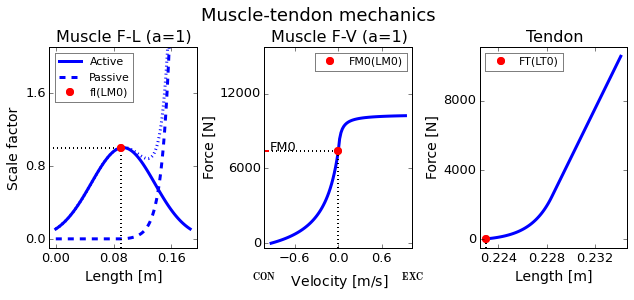

In [5]:
ms.muscle_plot()

Let's simulate an isometric activation (and since we didn't enter an activation level, $a=1$ will be used):

In [6]:
def lmt_eq(t, lmt0):
    # isometric activation
    
    lmt = lmt0
    
    return lmt

ms.lmt_eq = lmt_eq

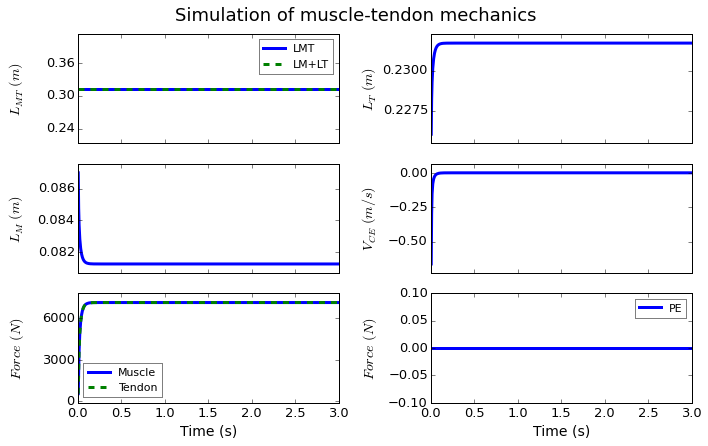

In [7]:
data = ms.lm_sol()

We can input a prescribed muscle-tendon length for the simulation:

In [8]:
def lmt_eq(t, lmt0):
    # prescribed change in the muscle-tendon length
    
    if t < 1:
        lmt = lmt0
    if 1 <= t < 2:
        lmt = lmt0 - 0.04*(t - 1)
    if t >= 2:
        lmt = lmt0 - 0.04

    return lmt

ms.lmt_eq = lmt_eq

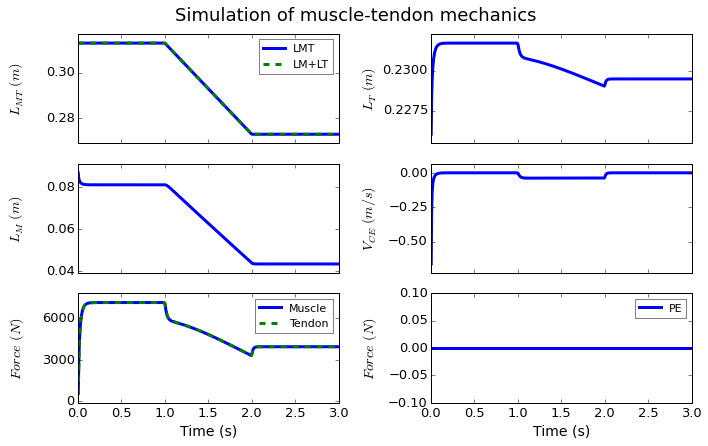

In [9]:
data = ms.lm_sol()

We can change the initial states to show the role of the passive parallel element:

In [10]:
ms.S = {'id': '', 'lt0': np.nan, 'lmt0': 0.323, 'lm0': 0.10, 'name': ''}

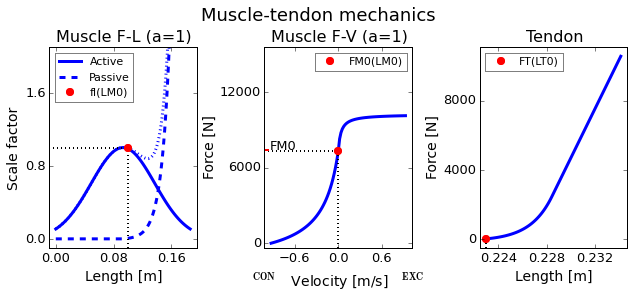

In [11]:
ms.muscle_plot()

Let's also change the excitation signal:

In [12]:
def excitation(t, u_max=1, u_min=0.01, t0=1, t1=2):
    """Excitation signal, a hat signal."""
    u = u_min
    if t >= t0 and t <= t1:
        u = u_max
    return u

ms.excitation = excitation

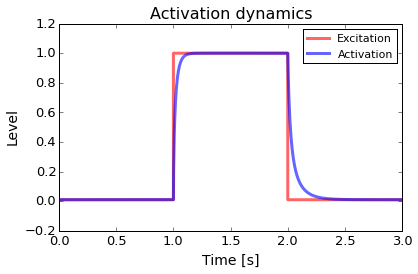

In [13]:
act = ms.activation_sol()

And let's simulate an isometric contraction:

In [14]:
def lmt_eq(t, lmt0):
    # isometric activation
    
    lmt = lmt0
    
    return lmt

ms.lmt_eq = lmt_eq

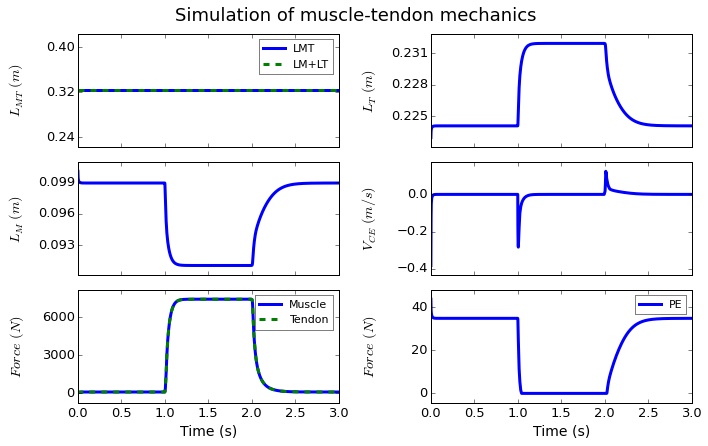

In [15]:
data = ms.lm_sol()

Let's use as excitation a train of pulses:

In [16]:
def excitation(t, u_max=.5, u_min=0.01, t0=.2, t1=2):
    """Excitation signal, a train of square pulses."""
    
    u = u_min
    ts = np.arange(1, 2.0, .1)
    #ts = np.delete(ts, np.arange(2, ts.size, 3))
    if t >= ts[0] and t <= ts[1]:
        u = u_max
    elif t >= ts[2] and t <= ts[3]:
        u = u_max
    elif t >= ts[4] and t <= ts[5]:
        u = u_max
    elif t >= ts[6] and t <= ts[7]:
        u = u_max
    elif t >= ts[8] and t <= ts[9]:
        u = u_max

    return u

ms.excitation = excitation

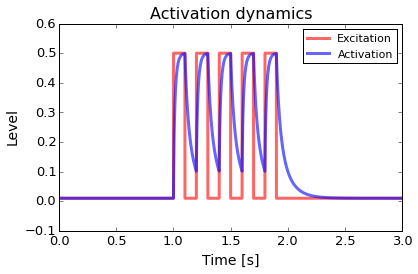

In [17]:
act = ms.activation_sol()

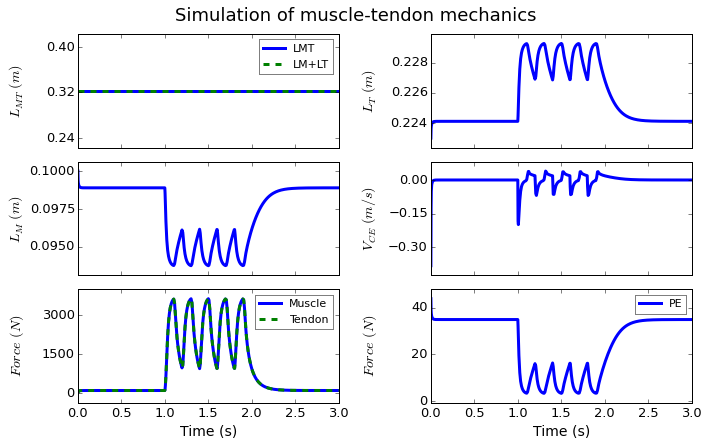

In [18]:
data = ms.lm_sol()

##References

- Kawakami Y, Ichinose Y, Fukunaga T (1998) [Architectural and functional features of human triceps surae muscles during contraction](http://www.ncbi.nlm.nih.gov/pubmed/9688711). Journal of Applied Physiology, 85, 398–404.  
- Nigg BM and Herzog W (2006) [Biomechanics of the Musculo-skeletal System](https://books.google.com.br/books?id=hOIeAQAAIAAJ&dq=editions:ISBN0470017678). 3rd Edition. Wiley.  
- Scott SH, Winter DA (1991) [A comparison of three muscle pennation assumptions and their effect on isometric and isotonic force](http://www.ncbi.nlm.nih.gov/pubmed/2037616). Journal of Biomechanics, 24, 163–167.  

## Module muscles.py

In [ ]:
# %load ./../functions/muscles.py
"""Muscle modeling and simulation."""

from __future__ import division, print_function
import numpy as np
from scipy.integrate import ode
import warnings
import configparser


__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'muscles.py v.1 2015/03/01'


class Thelen2003():
    """ Thelen (2003) muscle model.
    """

    def __init__(self, parameters=None, states=None):
        if parameters is not None:
            self.set_parameters(parameters)
        if states is not None:
            self.set_states(states)

        self.lm_data = []
        self.act_data = []


    def set_parameters(self, var=None):
        """Load and set parameters for the muscle model.
        """
        
        if var is None:
            var = './../data/muscle_parameter.txt'
        if isinstance(var, str):
            self.P = self.config_parser(var, 'parameters')
        elif isinstance(var, dict):
            self.P = var
        else:
            raise ValueError('Wrong parameters!')    
            
        print('The parameters were successfully loaded ' +
              'and are stored in the variable P.')
        

    def set_states(self, var=None):
        """Load and set states for the muscle model.
        """
        
        if var is None:
            var = './../data/muscle_state.txt'
        if isinstance(var, str):
            self.S = self.config_parser(var, 'states')
        elif isinstance(var, dict):
            self.S = var
        else:
            raise ValueError('Wrong states!')    
            
        print('The states were successfully loaded ' +
              'and are stored in the variable S.')
              

    def config_parser(self, filename, var):

        parser = configparser.ConfigParser()
        parser.optionxform = str  # make option names case sensitive
        parser.read(filename)
        if not parser:
            raise ValueError('File %s not found!' %var)
        #if not 'Muscle' in parser.sections()[0]:
        #    raise ValueError('Wrong %s file!' %var)
        var = {}
        for key, value in parser.items(parser.sections()[0]):
            if key.lower() in ['name', 'id']:
                var.update({key: value})
            else:
                try:
                    value = float(value)
                except ValueError:
                    print('"%s" value "%s" was replaced by NaN.' %(key, value))
                    value = np.nan
                var.update({key: value})
        
        return var   
        

    def force_l(self, lm, gammal=None):
        """Thelen (2003) force of the contractile element vs. muscle length.

        Parameters
        ----------
        lm : float
            normalized muscle fiber length
        gammal : float, optional (default from parameter file)
            shape factor

        Returns
        -------
        fl : float
            normalized force of the muscle contractile element
        """

        if gammal is None: gammal = self.P['gammal']

        fl = np.exp(-(lm-1)**2/gammal)
            
        return fl


    def force_pe(self, lm, kpe=None, epsm0=None):
        """Thelen (2003) force of the muscle parallel element vs. muscle length.
        
        Parameters
        ----------
        lm : float
            normalized muscle fiber length
        kpe : float, optional (default from parameter file)
            exponential shape factor
        epsm0 : float, optional (default from parameter file)
            passive muscle strain due to maximum isometric force
    
        Returns
        -------
        fpe : float
            normalized force of the muscle parallel (passive) element
        """
        
        if kpe is None: kpe = self.P['kpe']
        if epsm0 is None: epsm0 = self.P['epsm0']

        if lm <= 1:
            fpe = 0
        else:
            fpe = (np.exp(kpe*(lm-1)/epsm0)-1)/(np.exp(kpe)-1)
        
        return fpe
        
    
    def force_se(self, lt, ltslack=None, epst0=None, kttoe=None):
        """Thelen (2003) force-length relationship of tendon vs. tendon length.
        
        Parameters
        ----------
        lt : float
            tendon length (normalized or not)
        ltslack : float, optional (default from parameter file)
            tendon slack length (normalized or not)
        epst0 : float, optional (default from parameter file)
            tendon strain at the maximal isometric muscle force
        kttoe : float, optional (default from parameter file)
            linear scale factor
    
        Returns
        -------
        fse : float
            normalized force of the tendon series element
        """
    
        if ltslack is None: ltslack = self.P['ltslack']
        if epst0 is None: epst0 = self.P['epst0']
        if kttoe is None: kttoe = self.P['kttoe']

        epst = (lt-ltslack)/ltslack
        fttoe = .33
        # values from OpenSim Thelen2003Muscle
        epsttoe =  .99*epst0*np.e**3/(1.66*np.e**3 - .67)
        ktlin =  .67/(epst0 - epsttoe)
        #
        if epst <= 0:
            fse = 0
        elif epst <= epsttoe:
            fse = fttoe/(np.exp(kttoe)-1)*(np.exp(kttoe*epst/epsttoe)-1)
        else:
            fse = ktlin*(epst-epsttoe) + fttoe
            
        return fse
        
        
    def velo_fm(self, fm, a, fl, lmopt=None, vmmax=None, fmlen=None, af=None):
        """Thelen (2003) velocity of the force-velocity relationship vs. CE force.
        
        Parameters
        ----------
        fm : float
            normalized muscle force
        a : float
            muscle activation level
        fl : float
            normalized muscle force due to the force-length relationship
        lmopt : float, optional (default from parameter file)
            optimal muscle fiber length
        vmmax : float, optional (default from parameter file)
            normalized maximum muscle velocity for concentric activation
        fmlen : float, optional (default from parameter file)
            normalized maximum force generated at the lengthening phase
        af : float, optional (default from parameter file)
            shape factor
    
        Returns
        -------
        vm : float
            velocity of the muscle
        """

        if lmopt is None: lmopt = self.P['lmopt']
        if vmmax is None: vmmax = self.P['vmmax']
        if fmlen is None: fmlen = self.P['fmlen']
        if af is None: af = self.P['af']

        if fm <= a*fl:  # isometric and concentric activation
            if fm > 0:
                b = a*fl + fm/af
            else:
                b = a*fl
        else:           # eccentric activation
            asyE_thresh = 0.95  # from OpenSim Thelen2003Muscle
            if fm < a*fl*fmlen*asyE_thresh:
                b = (2 + 2/af)*(a*fl*fmlen - fm)/(fmlen - 1)
            else:
                fm0 = a*fl*fmlen*asyE_thresh
                b = (2 + 2/af)*(a*fl*fmlen - fm0)/(fmlen - 1)

        vm = (0.25  + 0.75*a)*1*(fm - a*fl)/b
        vm = vm*vmmax*lmopt

        return vm
        
        
    def force_vm(self, vm, a, fl, lmopt=None, vmmax=None, fmlen=None, af=None):
        """Thelen (2003) force of the contractile element vs. muscle velocity.
        
        Parameters
        ----------
        vm : float
            muscle velocity
        a : float
            muscle activation level
        fl : float
            normalized muscle force due to the force-length relationship
        lmopt : float, optional (default from parameter file)
            optimal muscle fiber length
        vmmax : float, optional (default from parameter file)
            normalized maximum muscle velocity for concentric activation
        fmlen : float, optional (default from parameter file)
            normalized normalized maximum force generated at the lengthening phase
        af : float, optional (default from parameter file)
            shape factor
    
        Returns
        -------
        fvm : float
            normalized force of the muscle contractile element
        """

        if lmopt is None: lmopt = self.P['lmopt']
        if vmmax is None: vmmax = self.P['vmmax']
        if fmlen is None: fmlen = self.P['fmlen']
        if af is None: af = self.P['af']

        vmmax = vmmax*lmopt
        if vm <= 0:  # isometric and concentric activation
            fvm = af*a*fl*(4*vm + vmmax*(3*a + 1))/(-4*vm + vmmax*af*(3*a + 1))
        else:        # eccentric activation
            fvm = a*fl*(af*vmmax*(3*a*fmlen - 3*a + fmlen - 1) + \
                  8*vm*fmlen*(af + 1)) / \
                  (af*vmmax*(3*a*fmlen - 3*a + fmlen - 1) + 8*vm*(af + 1))          
        
        return fvm
        
        
    def lmt_eq(self, t, lmt0=None):
        """Equation for muscle-tendon length."""

        if lmt0 is None:
            lmt0 = self.S['lmt0']
            
        return lmt0

        
    def vm_eq(self, t, lm, lm0, lmt0, lmopt, ltslack, alpha0, vmmax, fm0):
        """Equation for muscle velocity."""

        if lm < 0.1*lmopt:
            lm = 0.1*lmopt
        #lt0 = lmt0 - lm0*np.cos(alpha0)        
        a = self.activation(t)
        lmt = self.lmt_eq(t, lmt0)
        alpha = self.penn_ang(lmt=lmt, lm=lm, lm0=lm0, alpha0=alpha0)
        lt = lmt - lm*np.cos(alpha)
        fse = self.force_se(lt=lt, ltslack=ltslack)
        fpe = self.force_pe(lm=lm/lmopt)
        fl = self.force_l(lm=lm/lmopt)
        fce_t = fse/np.cos(alpha) - fpe
        #if fce_t < 0: fce_t=0
        vm = self.velo_fm(fm=fce_t, a=a, fl=fl)

        return vm


    def lm_sol(self, fun=None, t0=0, t1=3, lm0=None, lmt0=None, ltslack=None, lmopt=None,
               alpha0=None, vmmax=None, fm0=None,  show=True, axs=None):
        """Runge-Kutta (4)5 ODE solver for muscle length."""

        if lm0 is None: lm0 = self.S['lm0']
        if lmt0 is None: lmt0 = self.S['lmt0']
        if ltslack is None: ltslack = self.P['ltslack']
        if alpha0 is None: alpha0 = self.P['alpha0']
        if lmopt is None: lmopt = self.P['lmopt']
        if vmmax is None: vmmax = self.P['vmmax']
        if fm0 is None: fm0 = self.P['fm0']
        
        if fun is None:
            fun = self.vm_eq
        f = ode(fun).set_integrator('dopri5', nsteps=1, max_step=0.005, atol=1e-8)  
        f.set_initial_value(lm0, t0).set_f_params(lm0, lmt0, lmopt, ltslack, alpha0, vmmax, fm0)
        # suppress Fortran warning
        warnings.filterwarnings("ignore", category=UserWarning)
        data = []
        while f.t < t1:
            f.integrate(t1, step=True)
            d = self.calc_data(f.t, np.max([f.y, 0.1*lmopt]), lm0, lmt0,
                                           ltslack, lmopt, alpha0, fm0)
            data.append(d)

        warnings.resetwarnings()
        data = np.array(data)
        self.lm_data = data
        if show:
            self.lm_plot(data, axs)
        
        return data
        
        
    def calc_data(self, t, lm, lm0, lmt0, ltslack, lmopt, alpha0, fm0):
        """Calculus of muscle-tendon variables."""
        
        a = self.activation(t)
        lmt = self.lmt_eq(t, lmt0=lmt0)
        alpha = self.penn_ang(lmt=lmt, lm=lm, lm0=lm0, alpha0=alpha0)
        lt = lmt - lm*np.cos(alpha)
        fl = self.force_l(lm=lm/lmopt)
        fpe = self.force_pe(lm=lm/lmopt)
        fse = self.force_se(lt=lt, ltslack=ltslack)
        fce_t = fse/np.cos(alpha) - fpe
        vm = self.velo_fm(fm=fce_t, a=a, fl=fl, lmopt=lmopt)
        fm = self.force_vm(vm=vm, fl=fl, lmopt=lmopt, a=a) + fpe   
        data = [t, lmt, lm, lt, vm, fm*fm0, fse*fm0, a*fl*fm0, fpe*fm0]
        
        return data
            
    
    def muscle_plot(self, a=1, axs=None):
        """Plot muscle-tendon relationships with length and velocity."""

        try:
            import matplotlib.pyplot as plt
        except ImportError:
            print('matplotlib is not available.')
            return
        
        if axs is None:
            _, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
        
        lmopt   = self.P['lmopt']
        ltslack = self.P['ltslack']
        vmmax   = self.P['vmmax']
        alpha0  = self.P['alpha0']
        fm0     = self.P['fm0']
        lm0     = self.S['lm0']
        lmt0    = self.S['lmt0']
        lt0     = self.S['lt0']
        if np.isnan(lt0): lt0 = lmt0 - lm0*np.cos(alpha0)
        
        lm  = np.linspace(0, 2, 101)
        lt  = np.linspace(0, 1, 101)*0.05 + 1
        vm  = np.linspace(-1, 1, 101)*vmmax*lmopt
        fl  = np.zeros(lm.size)
        fpe = np.zeros(lm.size)
        fse = np.zeros(lt.size)
        fvm = np.zeros(vm.size)
        
        fl_lm0  = self.force_l(lm0/lmopt)
        fpe_lm0 = self.force_pe(lm0/lmopt)
        fm_lm0  = fl_lm0 + fpe_lm0
        ft_lt0  = self.force_se(lt0, ltslack)*fm0        
        
        for i in range(101):
            fl[i]  = self.force_l(lm[i])
            fpe[i] = self.force_pe(lm[i])
            fse[i] = self.force_se(lt[i], ltslack=1)
            fvm[i] = self.force_vm(vm[i], a=a, fl=fl_lm0)

        lm  = lm*lmopt
        lt  = lt*ltslack
        fl  = fl
        fpe = fpe
        fse = fse*fm0
        fvm = fvm*fm0
            
        xlim = self.margins(lm, margin=.05, minmargin=False)
        axs[0].set_xlim(xlim)
        ylim = self.margins([0, 2], margin=.05)
        axs[0].set_ylim(ylim)
        axs[0].plot(lm, fl, 'b', label='Active')
        axs[0].plot(lm, fpe, 'b--', label='Passive')
        axs[0].plot(lm, fl+fpe, 'b:', label='')
        axs[0].plot([lm0, lm0], [ylim[0], fm_lm0], 'k:', lw=2, label='')
        axs[0].plot([xlim[0], lm0], [fm_lm0, fm_lm0], 'k:', lw=2, label='')
        axs[0].plot(lm0, fm_lm0, 'o', ms=6, mfc='r', mec='r', mew=2, label='fl(LM0)')
        axs[0].legend(loc='best', frameon=True, framealpha=.5)
        axs[0].set_xlabel('Length [m]')
        axs[0].set_ylabel('Scale factor')
        axs[0].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[0].set_title('Muscle F-L (a=1)')
        
        xlim = self.margins([0, np.min(vm), np.max(vm)], margin=.05, minmargin=False)
        axs[1].set_xlim(xlim)
        ylim = self.margins([0, fm0*1.2, np.max(fvm)*1.5], margin=.025)
        axs[1].set_ylim(ylim)
        axs[1].plot(vm, fvm, label='')
        axs[1].set_xlabel('$\mathbf{^{CON}}\;$ Velocity [m/s] $\;\mathbf{^{EXC}}$')
        axs[1].plot([0, 0], [ylim[0], fvm[50]], 'k:', lw=2, label='')
        axs[1].plot([xlim[0], 0], [fvm[50], fvm[50]], 'k:', lw=2, label='')
        axs[1].plot(0, fvm[50], 'o', ms=6, mfc='r', mec='r', mew=2, label='FM0(LM0)')
        axs[1].plot(xlim[0], fm0, '+', ms=10, mfc='r', mec='r', mew=2, label='')
        axs[1].text(vm[0], fm0, 'FM0')
        axs[1].legend(loc='upper right', frameon=True, framealpha=.5)
        axs[1].set_ylabel('Force [N]')
        axs[1].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[1].yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[1].set_title('Muscle F-V (a=1)')

        xlim = self.margins([lt0, ltslack, np.min(lt), np.max(lt)], margin=.05,
                             minmargin=False)
        axs[2].set_xlim(xlim)
        ylim = self.margins([ft_lt0, 0, np.max(fse)], margin=.05)
        axs[2].set_ylim(ylim)
        axs[2].plot(lt, fse, label='')
        axs[2].set_xlabel('Length [m]')
        axs[2].plot([lt0, lt0], [ylim[0], ft_lt0], 'k:', lw=2, label='')
        axs[2].plot([xlim[0], lt0], [ft_lt0, ft_lt0], 'k:', lw=2, label='')
        axs[2].plot(lt0, ft_lt0, 'o', ms=6, mfc='r', mec='r', mew=2, label='FT(LT0)')
        axs[2].legend(loc='upper left', frameon=True, framealpha=.5)
        axs[2].set_ylabel('Force [N]')
        axs[2].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[2].yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[2].set_title('Tendon')  
        plt.suptitle('Muscle-tendon mechanics', fontsize=18, y=1.03)
        plt.tight_layout(w_pad=.1)
        plt.show()
        
        
    def lm_plot(self, x, axs):
        """Plot results of actdyn_ode45 function.
            data = [t, lmt, lm, lt, vm, fm*fm0, fse*fm0, fl*fm0, fpe*fm0]
        """

        try:
            import matplotlib.pyplot as plt
        except ImportError:
            print('matplotlib is not available.')
            return
        
        if axs is None:
            _, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10, 6))

        axs[0, 0].plot(x[:, 0], x[:, 1], 'b', label='LMT')
        axs[0, 0].plot(x[:, 0], x[:, 2] + x[:, 3], 'g--', label='LM+LT')
        ylim = self.margins(x[:, 1], margin=.1)
        axs[0, 0].set_ylim(ylim)
        axs[0, 0].legend(framealpha=.5, loc='best')
        
        axs[0, 1].plot(x[:, 0], x[:, 3], 'b')
        #axs[0, 1].plot(x[:, 0], lt0*np.ones(len(x)), 'r')
        ylim = self.margins(x[:, 3], margin=.1)
        axs[0, 1].set_ylim(ylim)
        
        axs[1, 0].plot(x[:, 0], x[:, 2], 'b')
        #axs[1, 0].plot(x[:, 0], lmopt*np.ones(len(x)), 'r')
        ylim = self.margins(x[:, 2], margin=.1)
        axs[1, 0].set_ylim(ylim)
        
        axs[1, 1].plot(x[:, 0], x[:, 4], 'b')
        ylim = self.margins(x[:, 4], margin=.1)
        axs[1, 1].set_ylim(ylim)
        
        axs[2, 0].plot(x[:, 0], x[:, 5], 'b', label='Muscle')
        axs[2, 0].plot(x[:, 0], x[:, 6], 'g--', label='Tendon')
        ylim = self.margins(x[:, [5, 6]], margin=.1)
        axs[2, 0].set_ylim(ylim)
        axs[2, 0].set_xlabel('Time (s)')
        axs[2, 0].legend(framealpha=.5, loc='best')
        
        axs[2, 1].plot(x[:, 0], x[:, 8], 'b', label='PE')
        ylim = self.margins(x[:, 8], margin=.1)
        axs[2, 1].set_ylim(ylim)
        axs[2, 1].set_xlabel('Time (s)')
        axs[2, 1].legend(framealpha=.5, loc='best')
        
        axs = axs.flatten()
        ylabel = ['$L_{MT}\,(m)$', '$L_{T}\,(m)$', '$L_{M}\,(m)$',
                  '$V_{CE}\,(m/s)$', '$Force\,(N)$', '$Force\,(N)$']
        for i, axi in enumerate(axs):
            axi.set_ylabel(ylabel[i], fontsize=14)
            axi.yaxis.set_major_locator(plt.MaxNLocator(4))
            axi.yaxis.set_label_coords(-.2, 0.5)

        plt.suptitle('Simulation of muscle-tendon mechanics', fontsize=18,
                     y=1.03)
        plt.tight_layout()
        plt.show()
        
        
    def penn_ang(self, lmt, lm, lt=None, lm0=None, alpha0=None):
        """Pennation angle.
        
        Parameters
        ----------
        lmt : float
            muscle-tendon length
        lt : float, optional (default=None)
            tendon length
        lm : float, optional (default=None)
            muscle fiber length
        lm0 : float, optional (default from states file)
            initial muscle fiber length
        alpha0 : float, optional (default from parameter file)
            initial pennation angle

        Returns
        -------
        alpha : float
            pennation angle
        """

        if lm0 is None: lm0 = self.S['lm0']
        if alpha0 is None: alpha0 = self.P['alpha0']

        alpha = alpha0
        if alpha0 != 0:
            w = lm0*np.sin(alpha0)
            if lm is not None:
                cosalpha = np.sqrt(1-(w/lm)**2)
            elif lmt is not None and lt is not None:
                cosalpha = 1/(np.sqrt(1 + (w/(lmt-lt))**2))
            alpha = np.arccos(cosalpha)
            
        if alpha > 1.4706289:  # np.arccos(0.1), 84.2608 degrees
            alpha = 1.4706289
        
        return alpha
        

    def excitation(self, t, u_max=None, u_min=None, t0=0, t1=5):
        """Excitation signal, a square wave.

        Parameters
        ----------
        t : float
            time instant [s]
        u_max : float (0 < u_max <= 1), optional (default from parameter file)
            maximum value for muscle excitation
        u_min : float (0 < u_min < 1), optional (default from parameter file)
            minimum value for muscle excitation
        t0 : float, optional (default=0)
            initial time instant for muscle excitation equals to u_max [s]
        t1 : float, optional (default=5)
            final time instant for muscle excitation equals to u_max [s]

        Returns
        -------
        u : float (0 < u <= 1)
            excitation signal
        """

        if u_max is None: u_max = self.P['u_max']
        if u_min is None: u_min = self.P['u_min']
        
        u = u_min
        if t >= t0 and t <= t1:
            u = u_max

        return u


    def activation_dyn(self, t, a, t_act=None, t_deact=None):
        """Thelen (2003) activation dynamics, the derivative of `a` at `t`.

        Parameters
        ----------
        t : float
            time instant [s]
        a : float (0 <= a <= 1)
            muscle activation
        t_act : float, optional (default from parameter file)
            activation time constant [s]
        t_deact : float, optional (default from parameter file)
            deactivation time constant [s]
    
        Returns
        -------
        adot : float 
            derivative of `a` at `t`
        """

        if t_act is None: t_act = self.P['t_act']
        if t_deact is None: t_deact = self.P['t_deact']
        
        u = self.excitation(t)
        if u > a:
            adot = (u - a)/(t_act*(0.5 + 1.5*a))
        else:
            adot = (u - a)/(t_deact/(0.5 + 1.5*a))

        return adot


    def activation_sol(self, fun=None, t0=0, t1=3, a0=0, u_min=None,
                       t_act=None, t_deact=None, show=True, axs=None):
        """Runge-Kutta (4)5 ODE solver for activation dynamics.

        Parameters
        ----------
        fun : function object, optional (default is None and `actdyn` is used)
            function with ODE to be solved
        t0 : float, optional (default=0)
            initial time instant for the simulation [s]
        t1 : float, optional (default=0)
            final time instant for the simulation [s]
        a0 : float, optional (default=0)
            initial muscle activation
        u_max : float (0 < u_max <= 1), optional (default from parameter file)
            maximum value for muscle excitation
        u_min : float (0 < u_min < 1), optional (default from parameter file)
            minimum value for muscle excitation
        t_act : float, optional (default from parameter file)
            activation time constant [s]
        t_deact : float, optional (default from parameter file)
            deactivation time constant [s]
        show : bool, optional (default = True)
            if True (1), plot data in matplotlib figure
        axs : a matplotlib.axes.Axes instance, optional (default = None)

        Returns
        -------
        data : 2-d array
            array with columns [time, excitation, activation]
            
        """

        if u_min is None: u_min = self.P['u_min']
        if t_act is None: t_act = self.P['t_act']
        if t_deact is None: t_deact = self.P['t_deact']
      
        if fun is None:
            fun = self.activation_dyn
        f = ode(fun).set_integrator('dopri5', nsteps=1, max_step=0.005, atol=1e-8)  
        f.set_initial_value(a0, t0).set_f_params(t_act, t_deact)
        # suppress Fortran warning
        warnings.filterwarnings("ignore", category=UserWarning)
        data = []
        while f.t < t1:
            f.integrate(t1, step=True)
            data.append([f.t, self.excitation(f.t), np.max([f.y, u_min])])
        warnings.resetwarnings()
        data = np.array(data)
        if show:
            self.actvation_plot(data, axs)

        self.act_data = data
        
        return data


    def activation(self, t=None):
        """Activation signal."""
        
        data = self.act_data        
        if t is not None and len(data):
            if t <= self.act_data[0, 0]:
                a = self.act_data[0, 2]
            elif t >= self.act_data[-1, 0]:
                a = self.act_data[-1, 2]
            else:
                a = np.interp(t, self.act_data[:, 0], self.act_data[:, 2])
        else:
            a = 1
            
        return a


    def actvation_plot(self, data, axs):
        """Plot results of actdyn_ode45 function."""

        try:
            import matplotlib.pyplot as plt
        except ImportError:
            print('matplotlib is not available.')
            return
            
        if axs is None:
            _, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
                
        axs.plot(data[:, 0], data[:, 1], color=[1, 0, 0, .6], label='Excitation')
        axs.plot(data[:, 0], data[:, 2], color=[0, 0, 1, .6], label='Activation')
        axs.set_xlabel('Time [s]')
        axs.set_ylabel('Level')
        axs.legend()
        plt.title('Activation dynamics')
        plt.tight_layout()
        plt.show()   
        
        
    def margins(self, x, margin=0.01, minmargin=True):
        """Calculate plot limits with extra margins.
        """
        rang = np.nanmax(x) - np.nanmin(x)
        if rang < 0.001 and minmargin:
            rang = 0.001*np.nanmean(x)/margin
            if rang < 1:
                rang = 1
        lim = [np.nanmin(x) - rang*margin, np.nanmax(x) + rang*margin]

        return lim
